# Classification Task - Baseline Model

In [1]:
import os
import pathlib
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
BRISC_DATA_PATH = pathlib.Path('brisc2025')
CLASSIFICATION_PATH = BRISC_DATA_PATH / 'classification_task'

In [3]:
for dirname, _, _ in os.walk(CLASSIFICATION_PATH):
    print(dirname)

brisc2025/classification_task
brisc2025/classification_task/test
brisc2025/classification_task/test/pituitary
brisc2025/classification_task/test/no_tumor
brisc2025/classification_task/test/glioma
brisc2025/classification_task/test/meningioma
brisc2025/classification_task/train
brisc2025/classification_task/train/pituitary
brisc2025/classification_task/train/no_tumor
brisc2025/classification_task/train/glioma
brisc2025/classification_task/train/meningioma


In [4]:
TRAIN_DATA_PATH = CLASSIFICATION_PATH / 'train'
TEST_DATA_PATH = CLASSIFICATION_PATH / 'test'

## Data Loading and Preprocessing

In [5]:
import torch
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

In [6]:
base_pipeline = v2.Compose([
    v2.Resize((256, 256)),
    v2.Grayscale(),
    v2.ToImage(),
    v2.ToDtype(torch.float32)
])

In [7]:
to_tensor = lambda x: torch.tensor(x, dtype=torch.long)

In [8]:
generator = torch.Generator().manual_seed(42)

# Datasets using 80% - 20% for training and validation
dataset = ImageFolder(TRAIN_DATA_PATH, transform=base_pipeline, target_transform=to_tensor)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=generator)

# Test dataset for final evaluation
test_dataset = ImageFolder(TEST_DATA_PATH, transform=base_pipeline, target_transform=to_tensor)

In [9]:
len(train_dataset), len(val_dataset), len(test_dataset)

(4000, 1000, 1000)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model Training and Validation

In [11]:
from torch import nn, optim
from torchmetrics import MetricCollection
from torchmetrics.classification import Accuracy, F1Score, Recall, Precision

In [12]:
# Set up accelerator if hardware is available
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.mps.is_available() else
    'cpu'
)

print(f"Accelerator: {device}")

Accelerator: mps


In [13]:
# Set up metrics to evaluate model with
metrics = MetricCollection({
    'accuracy': Accuracy(task='multiclass', num_classes=4),
    'f1_score': F1Score(task='multiclass', num_classes=4, average='macro'),
    'recall': Recall(task='multiclass', num_classes=4, average='macro'),
    'precision': Precision(task='multiclass', num_classes=4, average='macro'),
}).to(device)

train_metrics = metrics.clone(prefix='train_')
val_metrics = metrics.clone(prefix='val_')
test_metrics = metrics.clone(prefix='test_')

In [14]:
class BaselineModel(nn.Module):
    def __init__(self, in_channels: int = 1, output_size: int = 4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 64 * 64, 512),
            nn.Linear(512, 256),
            nn.Linear(256, output_size)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [15]:
def train_loop(model, dataloader, loss_fn, optimizer, metrics, *, device='cpu'):
    train_loss = 0
    num_batches = len(dataloader)

    model.train()
    metrics.reset()

    for batch, (image, label) in enumerate(dataloader):
        image = image.to(device)
        label = label.to(device)

        pred = model(image) # Assuming our loss expects logits
        loss = loss_fn(pred, label)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad() # Using not scheduler

        train_loss += loss.item() 
        metrics.update(pred, label)

    epoch_loss = train_loss / num_batches
    epoch_metrics = metrics.compute()

    print(f"Train Loss: {epoch_loss:.4f} - Train Accuracy: {epoch_metrics['train_accuracy']:.4f}")

    return epoch_loss, epoch_metrics

In [16]:
def test_loop(model, dataloader, loss_fn, metrics, *, device='cpu', mode='test'):
    test_loss = 0
    num_batches = len(dataloader)

    model.eval()
    metrics.reset()
    
    with torch.no_grad():
        for image, label in dataloader:
            image = image.to(device)
            label = label.to(device)
            
            pred = model(image)
            test_loss += loss_fn(pred, label).item()
            metrics.update(pred, label)

    epoch_loss = test_loss / num_batches
    epoch_metrics = metrics.compute()
    
    if mode == 'val':
        print(f"Val Loss: {epoch_loss:.4f} - Val Accuracy: {epoch_metrics['val_accuracy']:.4f}")
        return epoch_loss, epoch_metrics

    return epoch_metrics

In [17]:
model = BaselineModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

In [18]:
history = defaultdict(list)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n---------------')
    train_loss, t_metrics = train_loop(model, train_loader, loss_fn, optimizer, train_metrics, device=device)
    val_loss, v_metrics = test_loop(model, test_loader, loss_fn, val_metrics, device=device, mode='val')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    for (t_metric, v_metric) in zip(t_metrics, v_metrics):
        history[t_metric].append(t_metrics[t_metric].item())
        history[v_metric].append(v_metrics[v_metric].item())

Epoch 1
---------------
Train Loss: 13.1704 - Train Accuracy: 0.6545
Val Loss: 3.2873 - Val Accuracy: 0.7100
Epoch 2
---------------
Train Loss: 0.5806 - Train Accuracy: 0.8788
Val Loss: 0.8711 - Val Accuracy: 0.8590
Epoch 3
---------------
Train Loss: 0.1647 - Train Accuracy: 0.9517
Val Loss: 0.5143 - Val Accuracy: 0.8870
Epoch 4
---------------
Train Loss: 0.0609 - Train Accuracy: 0.9818
Val Loss: 1.1339 - Val Accuracy: 0.8280
Epoch 5
---------------
Train Loss: 0.0612 - Train Accuracy: 0.9827
Val Loss: 0.5833 - Val Accuracy: 0.9050
Epoch 6
---------------
Train Loss: 0.0196 - Train Accuracy: 0.9942
Val Loss: 0.5079 - Val Accuracy: 0.9150
Epoch 7
---------------
Train Loss: 0.0080 - Train Accuracy: 0.9977
Val Loss: 0.4915 - Val Accuracy: 0.9200
Epoch 8
---------------
Train Loss: 0.0022 - Train Accuracy: 0.9998
Val Loss: 0.5118 - Val Accuracy: 0.9160
Epoch 9
---------------
Train Loss: 0.0012 - Train Accuracy: 1.0000
Val Loss: 0.5398 - Val Accuracy: 0.9130
Epoch 10
---------------
Tr

## Model Evaluation

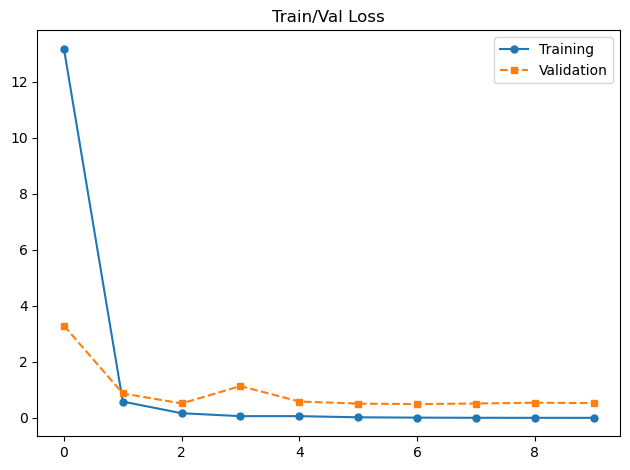

In [19]:
plt.plot(history['train_loss'], 'o-', markersize=5, label='Training')
plt.plot(history['val_loss'], 's--', markersize=5, label='Validation')
plt.title('Train/Val Loss')
plt.legend()

plt.tight_layout()
plt.show()

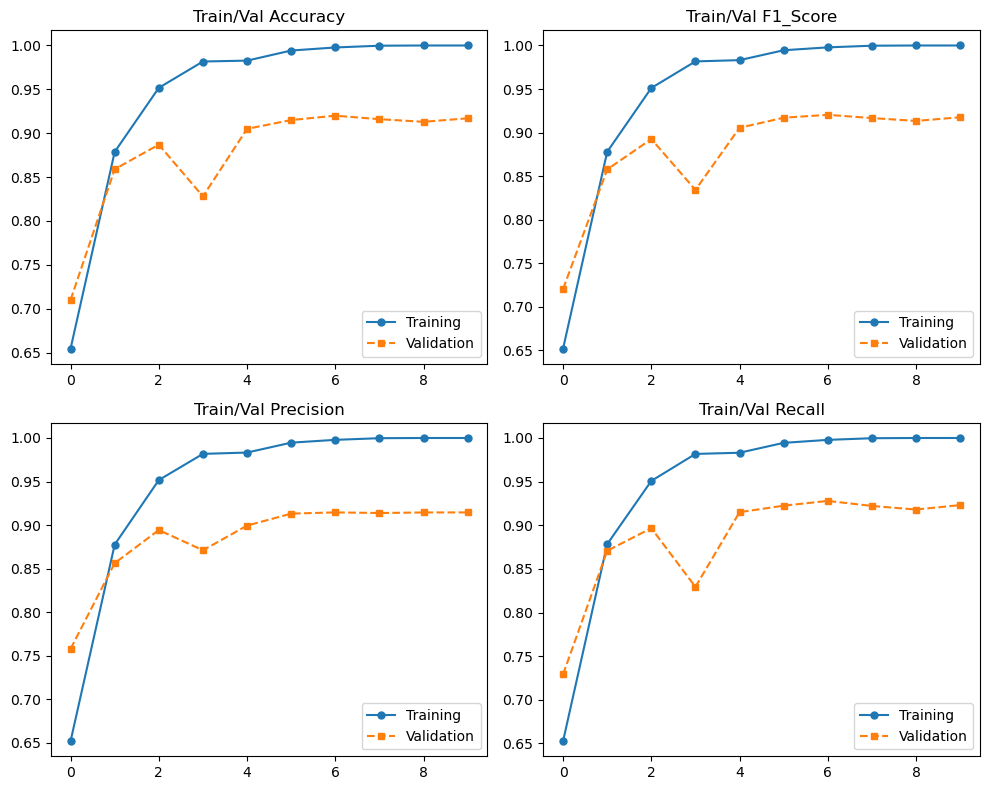

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, metric in enumerate(metrics.keys()):
    row = i // 2
    col = i % 2
    
    ax = axes[row, col]
    ax.plot(history[f'train_{metric}'], 'o-', markersize=5, label='Training')
    ax.plot(history[f'val_{metric}'], 's--', markersize=5, label='Validation')
    ax.set_title(f'Train/Val {metric.title()}')
    ax.legend()
plt.tight_layout()
plt.show()

### Performance in Test Set

In [21]:
final_metrics = test_loop(model, test_loader, loss_fn, test_metrics, device=device)

In [22]:
for metric, value in final_metrics.items():
    _, name = metric.split('_', 1)
    print(f'{name.title()}: {value.item():4f}')

Accuracy: 0.917000
F1_Score: 0.917646
Precision: 0.914542
Recall: 0.923131


## Save Model

In [23]:
model_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f'This model has: {model_params} params')

This model has: 67246532 params


In [24]:
from utils.io import save_model

In [25]:
save_model(model, 'class-baseline.pth')